# Hantush response functions

This notebook compares the two implementations of the Hantush response function in Pastas.

*Developed by D.A. Brakenhoff (Artesia, 2021)*


## Contents

- [`Hantush` versus `HantushWellModel`](#`Hantush`-versus-`HantushWellModel`)
- [Which Hantush should I use?](#Which-Hantush-should-I-use?)
- [Synthetic example](#Synthetic-example)

In [1]:
import numpy as np
import pandas as pd
import pastas as ps

ps.show_versions()
ps.logger.setLevel("WARNING")

Python version: 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
Numpy version: 1.20.3
Scipy version: 1.7.1
Pandas version: 1.3.4
Pastas version: 0.21.0b
Matplotlib version: 3.4.3


## `Hantush` versus `HantushWellModel`

There are two implementations of the Hantush response functions in Pastas. The two implementations are very similar, but they differ in their intended application and their definition of the parameters. The table below shows the formulas for both implementations.


| Name             | Fitting parameters  | Formula                                                                 | Description                                                                    |
|------------------|-------------|:------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| Hantush          | 3 - A, a, b | $$ \theta(t) = \frac{A}{2t \text{K}_0 \left(2 \sqrt{b} \right)} e^{-t/a - ab/t} $$                               | Response function commonly used for groundwater abstraction wells.             |
| HantushWellModel | 3 - A', a, b' | $$ \theta(r,t) = \frac{A^\prime}{2t} e^{-t/a - ab^\prime r^2/t} $$ | Implementation of the Hantush well function that allows scaling with distance. |

The Hantush response function is intended for the simulation of the effect of a single pumping well. 
The Hantush implementation has three parameters: $A$, $a$, and $b$.  
The parameter $A$ is also known as the "gain", which is equal to the steady-state contribution of a stress with unit 1. For example, the drawdown caused by a well with a continuous extraction rate of 1.0 (the units are determined by the units of the stress and head used in the model). The relationship between the parameters $A$, $a$, and $b$ and the physical parameters of the classic Hantush function are given in the notebook 'response_functions.ipynb'.

The HantushWellModel also has three parameters: $A^\prime$, $a$, and $b'$. The HantushWellModel response function includes the distance $r$ between an extraction well and an observation well, which must be defined by the user as an input variable. This allows multiple wells to have the same response function, scaled by the distance $r$, which can be useful to reduce the number of parameters in a model with multiple extraction wells. Note that $r$ is a variable that must be provided by the user and is not a parameter that is optimized. The gain of the HantushWellModel function is
$A^\prime \text{K}_0 \left( 2 r \sqrt{b^\prime} \right)$



The relationship between the parameters of the Hantush function and the HantushWellModel function are
$$
\begin{align*}
\frac{A}{\text{K}_0(2r\sqrt{b})} &= A^\prime \\
a &= a \\
b &= b'r^2
\end{align*}
$$



## Pros and cons of both functions

There advantages and disadvantages of both implementations are listed below.

#### Hantush

**Pro**:
- Parameter A is the gain, which makes it easier to interpret the results.
- Estimates the uncertainty of the gain directly.

**Con**:
- Cannot be used to simulate multiple wells.

#### HantushWellModel

**Pro**:
- Can be used with WellModel to simulate multiple wells with one response function.

**Con**:
- Does not directly estimate the uncertainty of the gain; the uncertainty of the gain must be calculated using special methods.
- More sensitive to the initial value of parameters. , The initial parameter values may have to be tweaked to get a good fit result.


So which one should you use? It depends on your use-case:

- Use `Hantush` if you are considering a single extraction well and you're interested in calculating the gain and the uncertainty of the gain.
- Use `HantushWellModel` if you are simulating multiple extraction wells or want to pass the distance between extraction and observation well as a known parameter.

## Synthetic example 

A synthetic example is used to show both Hantush implementations. First, we create a synthetic timeseries generated with the Hantush response function to which we add autocorrelated residuals. We set the parameter values for the Hantush response function:

In [2]:
# A defined so that 100 m3/day results in 5 m drawdown
Q = 100.0  # m3/day
A = -5 / Q 
a = 200
b = 0.5

d = 0.0  # reference level

In [3]:
# auto-correlated residuals AR(1)
sigma_n = 0.05
alpha = 50
sigma_r = sigma_n / np.sqrt(1 - np.exp(-2 * 14 / alpha))
print(f'sigma_r = {sigma_r:.2f} m')

sigma_r = 0.08 m


Create a head observations timeseries and a timeseries with the well extraction rate.

In [4]:
# head observations between 2000 and 2010
idx = pd.date_range("2000", "2010", freq="D")
ho = pd.Series(index=idx, data=0)

# extraction of 100 m3/day between 2002 and 2006
well = pd.Series(index=idx, data=0.0)
well.loc["2002":"2006"] = 100.0

Create the synthetic head timeseries based on the extraction rate and the parameters we defined above.

In [5]:
ml0 = ps.Model(ho) # alleen de tijdstippen waarop gemeten is worden gebruikt
rm = ps.StressModel(well, ps.Hantush, name='well', up=False)
ml0.add_stressmodel(rm)
ml0.set_parameter('well_A', initial=A)
ml0.set_parameter('well_a', initial=a)
ml0.set_parameter('well_b', initial=b)
ml0.set_parameter('constant_d', initial=d)
hsynthetic_no_error = ml0.simulate()[ho.index]

Add the auto-correlated residuals.

In [6]:
delt = (ho.index[1:] - ho.index[:-1]).values / pd.Timedelta("1d")
np.random.seed(1)
noise = sigma_n * np.random.randn(len(ho))
residuals = np.zeros_like(noise)
residuals[0] = noise[0]
for i in range(1, len(ho)):
    residuals[i] = np.exp(-delt[i - 1] / alpha) * residuals[i - 1] + noise[i]
hsynthetic = hsynthetic_no_error + residuals

Plot the timeseries.

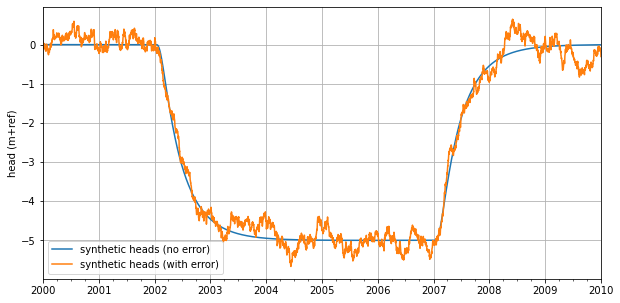

In [7]:
ax = hsynthetic_no_error.plot(label='synthetic heads (no error)', figsize=(10, 5))
hsynthetic.plot(ax=ax, color="C1", label="synthetic heads (with error)")
ax.legend(loc='best')
ax.set_ylabel("head (m+ref)")
ax.grid(visible=True)

Create three models:

1. Model with `Hantush` response function.
2. Model with `HantushWellModel` response function, but $r$ is not passed as a known parameter.
3. Model with `WellModel`, which uses `HantushWellModel` and where $r$ is set to 1.0 m.

All three models should yield the similar results and be able to estimate the true values of the parameters reasonably well.

In [8]:
# Hantush
ml_h1 = ps.Model(hsynthetic, name="gain")
wm_h1 = ps.StressModel(well, ps.Hantush, name='well', up=False)
ml_h1.add_stressmodel(wm_h1)
ml_h1.solve(report=False, noise=True)

Solve with noise model and Hantush_scaled

In [9]:
# HantushWellModel
ml_h2 = ps.Model(hsynthetic, name="scaled")
wm_h2 = ps.StressModel(well, ps.HantushWellModel, name='well', up=False)
ml_h2.add_stressmodel(wm_h2)
ml_h2.solve(report=False, noise=True)

In [10]:
# WellModel
r = np.array([1.0])  # parameter r
well.name = "well"

ml_h3 = ps.Model(hsynthetic, name="wellmodel")
wm_h3 = ps.WellModel([well], ps.HantushWellModel, "well", r, up=False)
ml_h3.add_stressmodel(wm_h3)
ml_h3.solve(report=False, noise=True, solver=ps.LmfitSolve)

Plot a comparison of all three models. The three models all yield similar results (all the lines overlap). 

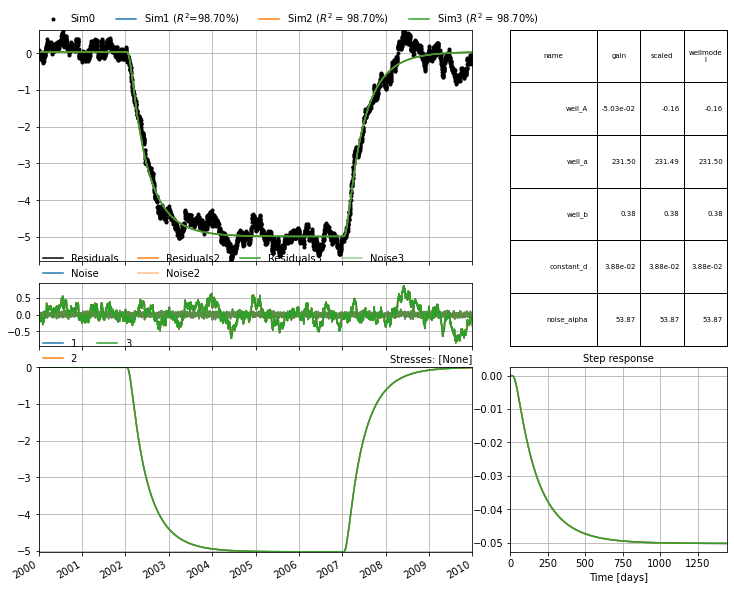

In [11]:
axes = ps.plots.compare([ml_h1, ml_h2, ml_h3], adjust_height=True, 
                        figsize=(10, 8));

Compare the optimized parameters for each model with the true values we defined at the beginning of this example. Note that we're comparing the value of the gain (not parameter $A$) and that each model has its own method for calculating the gain. As expected, the parameter estimates are reasonably close to the true values defined above.

In [12]:
df = pd.DataFrame(index=["well_gain", "well_a", "well_b"], 
                  columns=["True value", "Hantush", 
                           "HantushWellModel", "WellModel"])

df["True value"] = A, a, b

df["Hantush"] = (
    # gain (same as A in this case)
    wm_h1.rfunc.gain(ml_h1.get_parameters("well")),
    # a
    ml_h1.parameters.loc["well_a", "optimal"],
    # b
    ml_h1.parameters.loc["well_b", "optimal"] 
)

df["HantushWellModel"] = (
    # gain (not same as A)
    wm_h2.rfunc.gain(ml_h2.get_parameters("well")), 
    # a
    ml_h2.parameters.loc["well_a", "optimal"],
    # b
    ml_h2.parameters.loc["well_b", "optimal"]
)

df["WellModel"] = (
    # gain, use WellModel.get_parameters() to get params: A, a, b and r
    wm_h3.rfunc.gain(wm_h3.get_parameters(model=ml_h3, istress=0)),  
    # a
    ml_h3.parameters.loc["well_a", "optimal"],  
    # b (multiply parameter value by r^2 for comparison)
    ml_h3.parameters.loc["well_b", "optimal"] * r[0]**2  
)

df

,True value,Hantush,HantushWellModel,WellModel
well_gain,-0.05,-0.050272,-0.050272,-0.050272
well_a,200.00,231.499115,231.494510,231.500330
well_b,0.50,0.376506,0.376514,0.376502


Recall from earlier that when using `ps.Hantush` the gain and uncertainty of the gain are calculated directly. This is not the case for `ps.HantushWellModel`, so to obtain the uncertainty of the gain when using that response function there is a method called `ps.HantushWellModel.variance_gain()` that computes the variance based on the optimal values and (co)variance of parameters $A'$ and $b'$. 

The code below shows the calculated gain for each model, and how to calculate the variance and standard deviation of the gain for each model. The results show that the calculated values are all very close, as would be expected.

In [13]:
def variance_gain(ml, wm_name, istress=None):
    """Calculate variance of the gain for WellModel.

    Variance of the gain is calculated based on propagation of
    uncertainty using optimal values and the variances of A and b
    and the covariance between A and b.

    Parameters
    ----------
    ml : pastas.Model
        optimized model
    wm_name : str
        name of the WellModel
    istress : int or list of int, optional
        index of stress to calculate variance of gain for

    Returns
    -------
    var_gain : float
        variance of the gain calculated from model results
        for parameters A and b

    See Also
    --------
    pastas.HantushWellModel.variance_gain

    """
    wm = ml.stressmodels[wm_name]
    
    if ml.fit is None:
        raise AttributeError("Model not optimized! Run solve() first!")
    if wm.rfunc._name != "HantushWellModel":
        raise ValueError("Response function must be HantushWellModel!")

    # get parameters and (co)variances
    A = ml.parameters.loc[wm_name + "_A", "optimal"]
    b = ml.parameters.loc[wm_name + "_b", "optimal"]
    var_A = ml.fit.pcov.loc[wm_name + "_A", wm_name + "_A"]
    var_b = ml.fit.pcov.loc[wm_name + "_b", wm_name + "_b"]
    cov_Ab = ml.fit.pcov.loc[wm_name + "_A", wm_name + "_b"]

    if istress is None:
        r = np.asarray(wm.distances)
    elif isinstance(istress, int) or isinstance(istress, list):
        r = wm.distances[istress]
    else:
        raise ValueError("Parameter 'istress' must be None, list or int!")

    return wm.rfunc.variance_gain(A, b, var_A, var_b, cov_Ab, r=r)

In [14]:
# create dataframe
var_gain = pd.DataFrame(index=df.columns[1:])

# add calculated gain
var_gain["gain"] = df.iloc[0, 1:].values

# Hantush: variance gain is computed directly
var_gain.loc["Hantush", "var gain"] = ml_h1.fit.pcov.loc["well_A", "well_A"]

# HantushWellModel: calculate variance gain
var_gain.loc["HantushWellModel", "var gain"] = wm_h2.rfunc.variance_gain(
    ml_h2.parameters.loc["well_A", "optimal"],  # A
    ml_h2.parameters.loc["well_b", "optimal"],  # b
    ml_h2.fit.pcov.loc["well_A", "well_A"],  # var_A
    ml_h2.fit.pcov.loc["well_b", "well_b"],  # var_b
    ml_h2.fit.pcov.loc["well_A", "well_b"]  # cov_Ab
)

# WellModel: calculate variance gain using helper function
var_gain.loc["WellModel", "var gain"] = variance_gain(ml_h3, "well", istress=0)

# calculate std dev gain
var_gain["std gain"] = np.sqrt(var_gain["var gain"])

# show table
var_gain.style.format("{:.5e}")

,gain,var gain,std gain
Hantush,-5.02721e-02,1.24683e-06,1.11662e-03
HantushWellModel,-5.02720e-02,1.24687e-06,1.11663e-03
WellModel,-5.02722e-02,1.24618e-06,1.11632e-03
